In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/task2bert/task2_test.csv
/kaggle/input/task2bert/task2_train.csv
/kaggle/input/maindatasetfinal2/train_task2.csv


In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import TFBertModel

from imblearn.over_sampling import SMOTE
from imblearn.combine import *
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import keras
import os
import re 

In [3]:
def preprocess(text):
  
  text=text.lower()
  text=re.sub(r'rt\s*@[^:]*:\s', ' ', text)
  text=re.sub(r'[^A-Za-z0-9]+', ' ', text)
  text=re.sub(r' t .*$', '', text)
  text=re.sub(r'\b[a-zA-Z]\b', '', text)
  text=re.sub(r'/^\s+|\s+$|\s+(?=\s)/g', '', text);
  text = re.sub(r's+[a-zA-Z]s+', '', text)
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text=re.sub(r'https?','',text)
  text=re.sub(r'#[A-Za-z0-9_]+','',text)
  text=re.sub(r'\.\.\.',' ',text)
  text=text.replace('…',' ')
  text=text.replace('..',' ')
  text=re.sub(r'@\w*',r'',text)
  text=re.sub(r'\s{2,}',r' ',text)
  text=re.sub(r'$[\s]+','',text)
  text=text.replace('&amp','')
  text=text.replace('&gt','')
  text=text.replace('&lt','')
  text=re.sub(r'([\w\d]+)([^\w\d ]+)', r'\1 \2',text)
  text=re.sub(r'([^\w\d ]+)([\w\d]+)', r'\1 \2',text)
 
  return text

In [4]:
train = pd.read_csv('../input/maindatasetfinal2/train_task2.csv')
train

,tweet_text,text_human_class,type
0,no an undocumented immigrant did not start the...,non_informative,1
1,the massage therapi reaching out to those caug...,humanitarian,0
2,morning meeting we continue to tackle the dam...,structure,2
3,still waiting for my power to come back after ...,non_informative,1
4,floridians with solarpanels were able to get e...,non_informative,1
...,...,...,...
27522,last tripadvisor review restaurant in amatrice...,structure,2
27523,drone shows damage around amatrice as rescue ...,structure,2
27524,convent among collapsed buildings in amatrice...,structure,2
27525,the sun ri over collapsed buildings following...,structure,2


In [5]:
test = pd.read_csv('../input/task2bert/task2_test.csv', index_col = 0)
del(test["tweet_id"])
del(test["image_id"])
del(test["image_path"])
del(test["text_info_conf"])
del(test["image_info"])
del(test["image_info_conf"])
del(test["text_human"])
del(test["text_human_conf"])
del(test["image_human"])
del(test["image_human_conf"])
del(test["image_damage"])
del(test["image_damage_conf"])
del(test["image_url"])
del(test["Unnamed: 0.1"])
del(test["image_human_class"])
del(test["text_info"])

test["tweet_text"]=test["tweet_text"].apply(lambda x: preprocess(x))
test["type"] = test["text_human_class"].apply(lambda x: 0 if x == "humanitarian" else 1 if x == "non_informative" else 2)

test


,tweet_text,text_human_class,type
11755,selling popcorn at lunch to benefit victims of...,humanitarian,0
1157,not only california northern spain amp portuga...,non_informative,1
16557,5pm tuesday tropical update maria still catego...,non_informative,1
7679,3 scenes of landsat ingested to hdds for event...,non_informative,1
196,realomarnavarro schnauzermom777 can you stop ...,non_informative,1
...,...,...,...
2888,my town in pr after hurricane maria,non_informative,1
8619,stiletto in texas it more than shoe it an att...,non_informative,1
16509,help our members affected by harvey and irma d...,humanitarian,0
1418,california wine country wildfires near contain...,non_informative,1


In [6]:
train["type"].value_counts()

0    9549
1    9305
2    8673
Name: type, dtype: int64

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-05-16 21:17:55.958352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 21:17:55.960222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 21:17:55.961408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 21:17:55.962774: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
tokenized_train = train["tweet_text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=60)))
tokenized_test = test["tweet_text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=60)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [9]:
max_len = 60

In [10]:
input_ids_train= np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])
attention_mask_train= np.where(input_ids_train!= 0, 1, 0)

input_ids_test= np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
attention_mask_test=np.where(input_ids_test!= 0, 1, 0)

In [11]:
arr_train = train["type"].values
arr_test = test["type"].values

num_samples_train = len(train)
num_samples_test = len(test)

labels_train = np.zeros((num_samples_train, arr_train.max()+1))
labels_test = np.zeros((num_samples_test, arr_test.max()+1))

labels_train[np.arange(num_samples_train), arr_train] = 1
labels_test[np.arange(num_samples_test), arr_test] = 1

In [12]:
dataset_train = tf.data.Dataset.from_tensor_slices((input_ids_train,attention_mask_train,labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((input_ids_test,attention_mask_test,labels_test))

def map_func(input_ids, masks, labels):
    return {'input_ids' : input_ids, 'attention_mask' : masks}, labels

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

In [13]:
dataset_train = dataset_train.shuffle(4800)

dataset_train = dataset_train.batch(128)
dataset_test = dataset_test.batch(8)

In [14]:
input_ids = tf.keras.layers.Input(shape=(max_len,), name = "input_ids", dtype = 'int32')
mask = tf.keras.layers.Input(shape=(max_len,), name = "attention_mask", dtype = 'int32')

embeddings = bert.bert(input_ids, attention_mask=mask)
hidden_layers = embeddings[2]

conc_layer1 = hidden_layers[-4]
conc_layer2 = hidden_layers[-3]
conc_layer3 = hidden_layers[-2]
conc_layer4 = hidden_layers[-1]

conc = tf.keras.layers.Concatenate()([conc_layer1, conc_layer2, conc_layer3, conc_layer4])

lstm = tf.keras.layers.GRU(128, return_sequences=True)(conc)
lstm = tf.keras.layers.Dropout(0.2)(lstm)
lstm = tf.keras.layers.GRU(64)(lstm)
lstm = tf.keras.layers.Dropout(0.2)(lstm)
lstm = tf.keras.layers.Dense(32)(lstm)

y = tf.keras.layers.Dense(3, activation="softmax", name="outputs")(lstm)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, mask], outputs = [y])

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5, decay = 0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = keras.callbacks.ModelCheckpoint('/kaggle/working/best_model_BERT_task2-conclayers.h5', monitor='val_loss', mode='min', save_best_only=True)

#class_weights = {1: 0.1288,
#                0: 0.3084,
#                2: 1.0072}

model.compile(optimizer=optimizer, loss = loss, metrics = metrics)

In [17]:
history = model.fit(
    dataset_train,
    validation_data = dataset_test,
    epochs = 100,
    callbacks=[es,mc]
)

Epoch 1/100


2022-05-16 21:18:45.645933: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-16 21:18:51.443146: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


216/216 [==============================] - 218s 926ms/step - loss: 0.4864 - accuracy: 0.8090 - precison: 0.8331 - recall: 0.7817 - val_loss: 0.9334 - val_accuracy: 0.6768 - val_precison: 0.6879 - val_recall: 0.6563
Epoch 2/100
216/216 [==============================] - 196s 908ms/step - loss: 0.3343 - accuracy: 0.8786 - precison: 0.8867 - recall: 0.8703 - val_loss: 0.8653 - val_accuracy: 0.6998 - val_precison: 0.7122 - val_recall: 0.6801
Epoch 3/100
216/216 [==============================] - 197s 911ms/step - loss: 0.3121 - accuracy: 0.8854 - precison: 0.8916 - recall: 0.8777 - val_loss: 0.8344 - val_accuracy: 0.7022 - val_precison: 0.7188 - val_recall: 0.6843
Epoch 4/100
216/216 [==============================] - 197s 911ms/step - loss: 0.2994 - accuracy: 0.8904 - precison: 0.8975 - recall: 0.8842 - val_loss: 0.7834 - val_accuracy: 0.7230 - val_precison: 0.7364 - val_recall: 0.7050
Epoch 5/100
216/216 [==============================] - 197s 912ms/step - loss: 0.2950 - accuracy: 0.8911

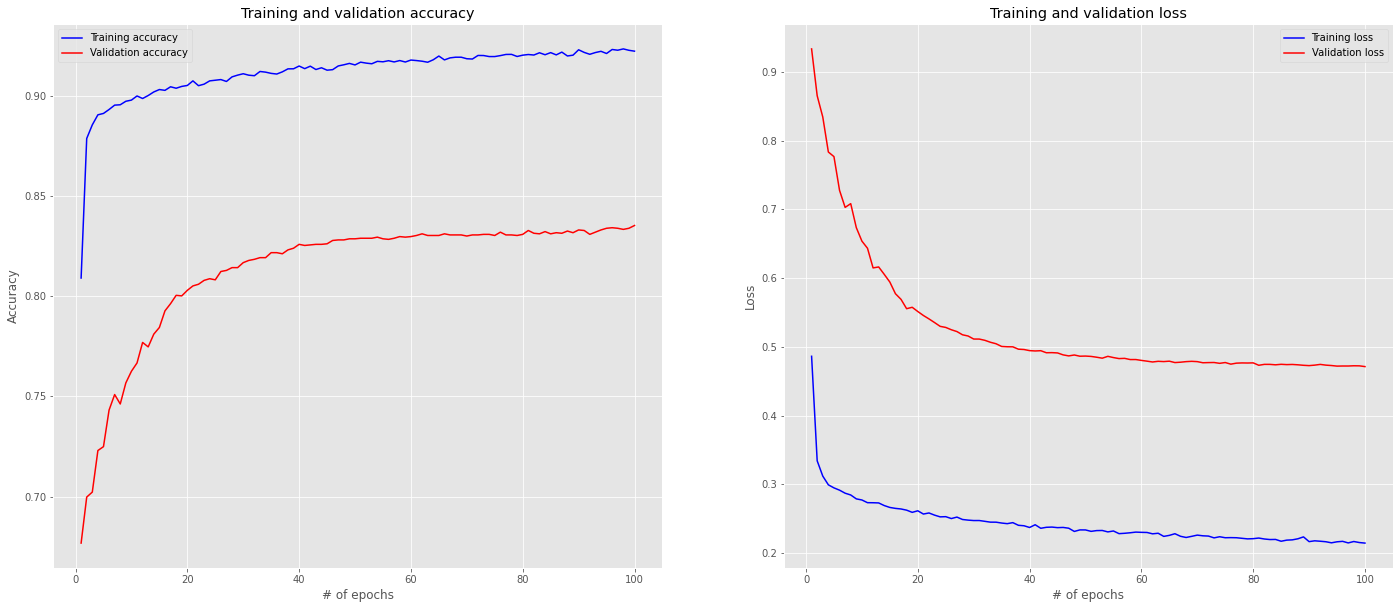

In [18]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('# of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('# of epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_history(history)

In [ ]:
from keras.models import load_model

saved_model = tf.keras.models.load_model('./best_model_BERT_task2-conclayers.h5')

In [20]:
y_pred = [] 
y_true = [] 

for inputs_id_mask_batch, class_batch in dataset_test:   
   y_true.append(np.argmax(class_batch, axis = -1))
   preds = saved_model.predict(inputs_id_mask_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

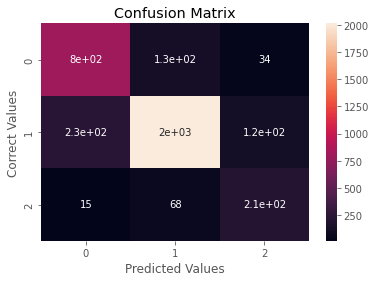


              precision    recall  f1-score   support

           0       0.77      0.83      0.80       958
           1       0.91      0.85      0.88      2367
           2       0.57      0.72      0.64       292

    accuracy                           0.84      3617
   macro avg       0.75      0.80      0.77      3617
weighted avg       0.85      0.84      0.84      3617



In [21]:
cm = confusion_matrix(correct_labels, predicted_labels)

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Correct Values')
plt.xlabel('Predicted Values')
plt.show()
print()
print(classification_report(correct_labels, predicted_labels))